In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

c:\Users\nerea\anaconda3\envs\sinthlab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

## Load the data

In [5]:
data_dir = "./Data"
#fname = os.path.join(data_dir, "Sansa_20180507.mat") --> only 7 baseline reaches
fname = os.path.join(data_dir, "Sansa_20180413.mat")

In [6]:
# load TrialData .mat file into a DataFrame
group_df = mat2dataframe(fname, shift_idx_fields=True, td_name='grp')

array field StimParamNames could not be converted to int.


c:\Users\nerea\OneDrive\Documentos\EPFL_MASTER\PDM\Project\PyalData\pyaldata\data_cleaning.py:68: RuntimeWarning: invalid value encountered in cast
  int_arrays = [np.int32(arr) for arr in df[field]]


In [7]:
# trial_df = mat2dataframe_NC(fname, shift_idx_fields=True, td_name = 'trial_data') --> works with data from 07/05
trial_df = mat2dataframe_NC(fname, shift_idx_fields=True, td_name = 'trial_data') 

array field kin_names could not be converted to int.
array field joint_names could not be converted to int.
array field stim_param_names could not be converted to int.


The main dataframe here is trial_df, the group one will be used if needed to add some variables to the other one.

In [8]:
df = trial_df

`Note` Here not sure if there should be a combination of bins to make it longer and incude more spikes, but I will keep if as the demo, with now 20ms bins. 

#### **Combine time-bins into longer ones**

In [9]:
td = combine_time_bins(df, 2)
# now each bin corresponds to 20ms of recording.

#### **Remove low-firing neurons**

In [10]:
td = remove_low_firing_neurons(td, "M1_spikes",  5)
td = remove_low_firing_neurons(td, "PMd_spikes", 5)

print("original: ", df.M1_spikes[0].shape)
print("removed:  ", td.M1_spikes[0].shape)

original:  (5235, 64)
removed:   (2617, 64)


c:\Users\nerea\OneDrive\Documentos\EPFL_MASTER\PDM\Project\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
c:\Users\nerea\OneDrive\Documentos\EPFL_MASTER\PDM\Project\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


#### **Transform signals**

In [11]:
td = transform_signal(td, "M1_spikes",  'sqrt')
td = transform_signal(td, "PMd_spikes", 'sqrt')
#here we change the motor and premotor cortex spikes by their square root

#### **Merge signals from multiple areas**

Signals from the pre-motor and motor cortex are now combines in one same variable, we do not consider the 2 regions as different but more as functionally working together.

In [12]:
td = merge_signals(td, ["M1_spikes", "PMd_spikes"], "both_spikes")

print(f"Merging M1 and PMd gives {td.M1_spikes[0].shape[1]} + {td.PMd_spikes[0].shape[1]} = {td.both_spikes[0].shape[1]} neurons")

Merging M1 and PMd gives 64 + 63 = 127 neurons


#### **Calculate firing rates from spikes**

In [13]:
# works on "_spikes" fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth')

#### **Keep only the successful trials**

#### For this part of the project we do not need perfect reach trials, only to decode the motor intention in baseline trials.

In [14]:
td['idx_end_complete'] = td.apply(lambda x: add_bad_idx(x['idx_end'], x['idx_bad']), axis=1)
# Apply the function to each row
td['bad_indices'] = td.apply(find_bad_indices, axis=1)

In [15]:
td_all = pd.concat([td,group_df.drop(columns = 'type')], axis = 1)

In [16]:
cols_to_search = ['index', 'num', 'type', 'KUKAPos',
               'idx_kuka_go', 'idx_reach', 'idx_end_complete',
               'bad_indices', 'x', 'y', 'z', 'angles', 'both_spikes', 'both_rates']
cols_to_keep = [c for c in cols_to_search if c in td_all.columns]
td_filt = td_all[cols_to_keep]

In [17]:
#td_filt = td_filt.loc[td_filt.type == 'BASELINE'].reset_index()

In [18]:
td_filt['test_start'] = td_filt['idx_reach'].apply(lambda x: x[0])

C:\Users\nerea\AppData\Local\Temp\ipykernel_6000\918602067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td_filt['test_start'] = td_filt['idx_reach'].apply(lambda x: x[0])


In [19]:
td_filt['test_end'] = td_filt['idx_end_complete'].apply(lambda x: x[0])

C:\Users\nerea\AppData\Local\Temp\ipykernel_6000\1192183913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td_filt['test_end'] = td_filt['idx_end_complete'].apply(lambda x: x[0])


In [20]:
tidy_df = build_tidy_df(td_filt, start_margin = 5)

In [21]:
tidy_df['target_pos'] = tidy_df.apply(lambda x: np.concatenate([x['x'][4:5], x['y'][4:5], x['z'][4:5]]), axis = 1)

In [22]:
tidy_df['id'] = tidy_df['trial_num'].astype(str) + '_' + tidy_df['reach_num'].astype(str)

In [23]:
path_to_save_data = './Data/Processed_Data/Tidy_Sansa_13_04.pkl'

In [24]:
with open(path_to_save_data, 'wb') as handle:
            pickle.dump(tidy_df, handle, protocol=4)

In [25]:
baseline_df = tidy_df.loc[tidy_df.type == 'BASELINE'].reset_index()

In [26]:
baseline_df.id.unique()

array(['0_0', '0_1', '0_2', '0_3', '0_4', '7_0', '7_1', '7_2', '7_3',
       '7_4', '8_0', '8_1', '8_2', '8_3', '8_4', '11_0', '11_1', '11_2',
       '11_3', '11_4'], dtype=object)

In [27]:
X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test = train_test_split(baseline_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Test trials  4
Val trials 3


In [28]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the optimization method on fold ', fold)


X_train = X_train[fold_num]
X_val = X_val[fold_num]
X_test = X_test[fold_num]
y_test = y_test[fold_num]
y_train = y_train[fold_num]
y_val = y_val[fold_num]


# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train.shape[1]
num_features = X_train.shape[1]

seq_length = 75

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  

seed = 42
torch.manual_seed(seed)



We are testing the optimization method on fold  0


In [96]:
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5
l1_ratio_reg = 0.5

lr = 0.0001
loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
hidden_units = 50
num_layers = 1
input_size = 60
dropout_1 = 0.4
dropout_2 = 0.25

#Other training hyperparameters

lr_gamma= 1.18 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM=12
batch_size_train= 30
batch_size_val = 28

Reg = globals().get(Regularizer_LSTM)

In [97]:
# Fit the LSTM model
model = CausalTemporalLSTM(num_features=num_features, 
                    hidden_units= hidden_units, #was 128
                    num_layers = num_layers, 
                    input_size = input_size,
                    out_dims = num_dim_output, 
                    dropout_1 = dropout_1, 
                    dropout_2 = dropout_2).to(device)

In [98]:
train_losses, val_losses = \
    train_model(model, xx_train,yy_train,
                xx_val, 
                yy_val,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer=Reg,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                
                )


Epoch 000 Train 0.0372 Val 0.0483
Epoch 001 Train 0.0332 Val 0.0440
Epoch 002 Train 0.0292 Val 0.0410
Epoch 003 Train 0.0252 Val 0.0351
Epoch 004 Train 0.0213 Val 0.0305
Epoch 005 Train 0.0181 Val 0.0278
Epoch 006 Train 0.0156 Val 0.0271
Epoch 007 Train 0.0135 Val 0.0220
Epoch 008 Train 0.0121 Val 0.0218
Epoch 009 Train 0.0109 Val 0.0210
Epoch 010 Train 0.0099 Val 0.0238
Epoch 011 Train 0.0090 Val 0.0196
Epoch 012 Train 0.0082 Val 0.0201
Epoch 013 Train 0.0076 Val 0.0189
Epoch 014 Train 0.0069 Val 0.0202
Epoch 015 Train 0.0064 Val 0.0194
Epoch 016 Train 0.0059 Val 0.0188
Epoch 017 Train 0.0055 Val 0.0212
Epoch 018 Train 0.0051 Val 0.0192
Epoch 019 Train 0.0048 Val 0.0195
Epoch 020 Train 0.0046 Val 0.0200
Decrease LR
Epoch 021 Train 0.0042 Val 0.0229
Epoch 022 Train 0.0041 Val 0.0197
Epoch 023 Train 0.0041 Val 0.0202
Epoch 024 Train 0.0039 Val 0.0219
Epoch 025 Train 0.0039 Val 0.0200
Decrease LR


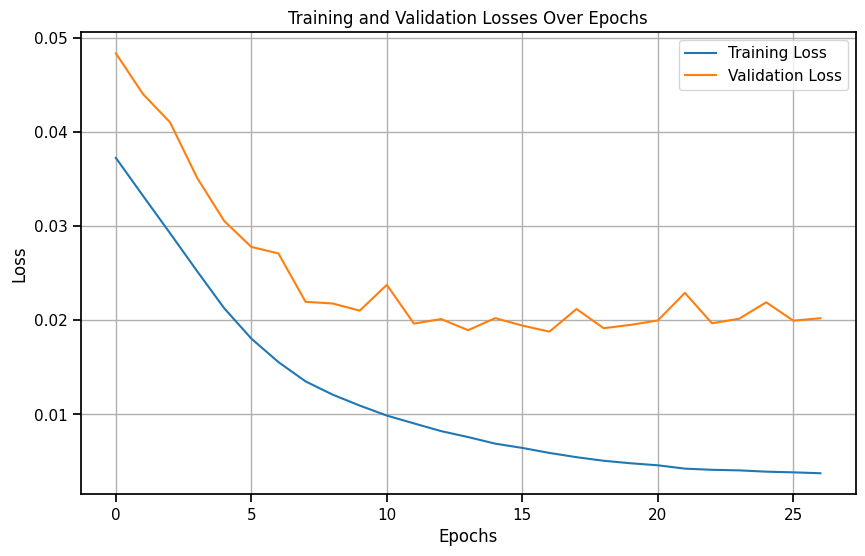

In [99]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [100]:
path_to_models = './Models'
experiment_name = 'LSTM_fold0_20180413_Baseline'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4)

In [101]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'ev')

Train EV: 0.84 
Val EV: 0.59 
Test EV: 0.46 


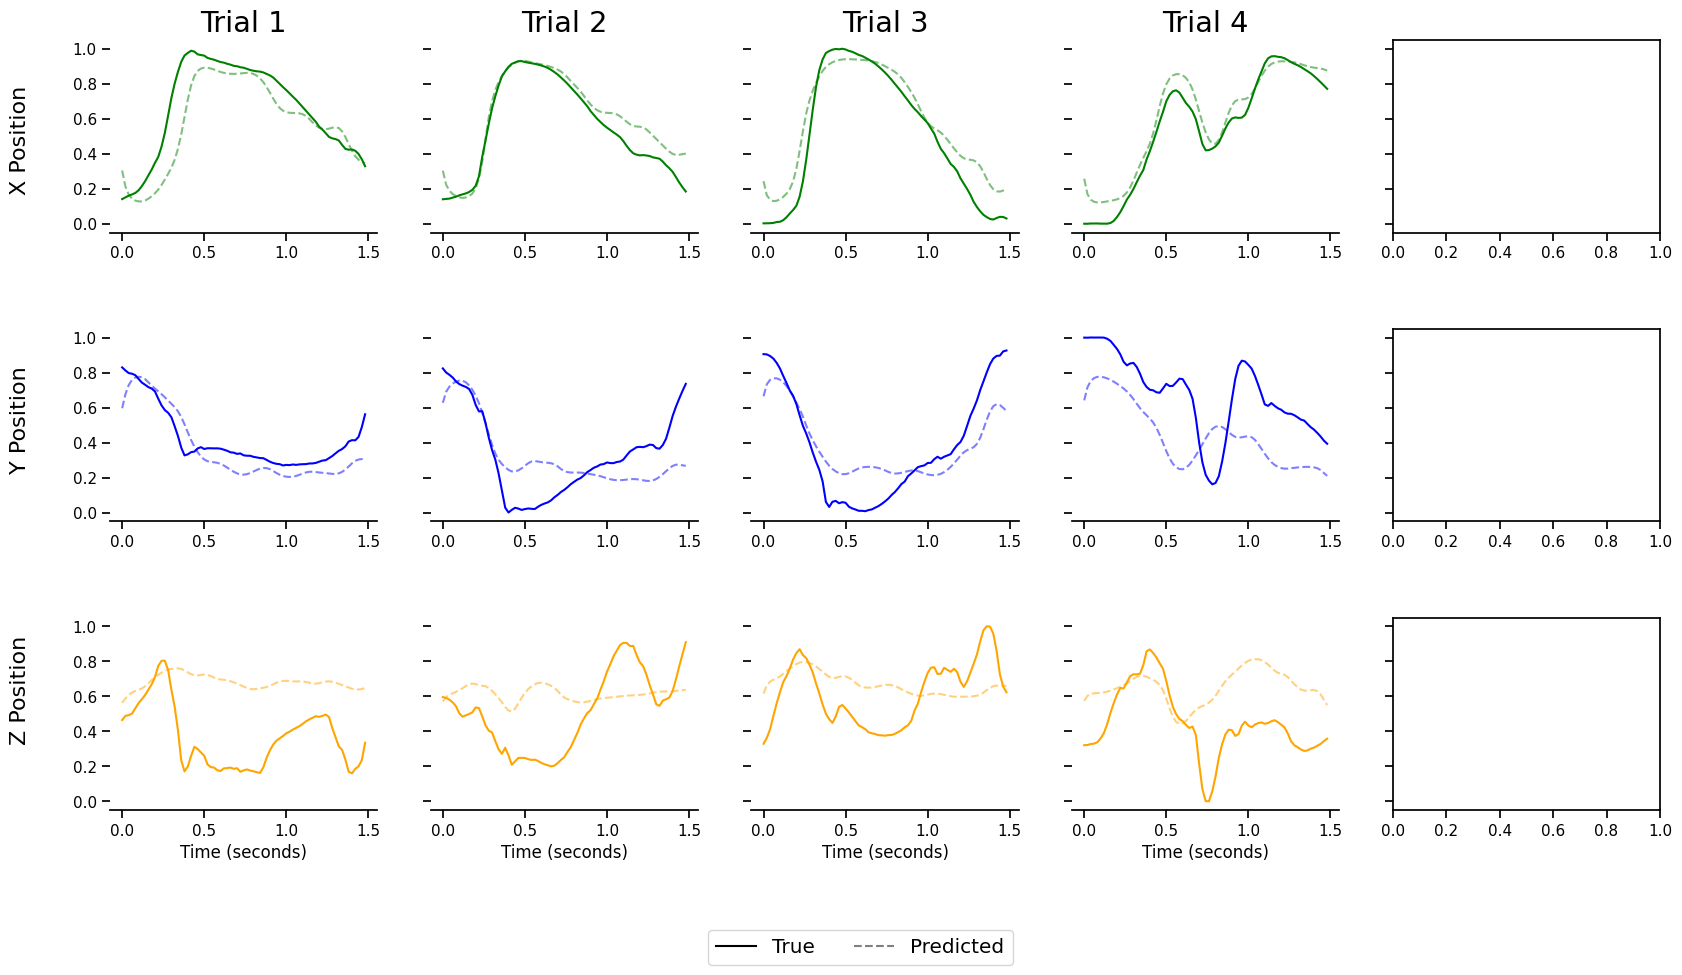

In [102]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)